In [8]:
# !pip install numpy requests nlpaug
# !pip install tensformers
# !pip install evaluate
# !pip install tensorboard
# !pip install accelerate -U
# !pip uninstall pillow
# !pip install pillow==9.4.0
import pandas as pd
import numpy as np

import torch

from sklearn.model_selection import train_test_split

from transformers import  TrainingArguments, Trainer
from transformers import BertTokenizer,BertForSequenceClassification

from transformers import BertForSequenceClassification

import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

import gc

In [9]:
torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:

torch.cuda.empty_cache()
gc.collect()

3659

#### Data

In [11]:
MAX_SENTENCE_LENGTH=150
data_url='../train-balanced-sarcasm.csv'
epochs=1

In [12]:

df=pd.read_csv(data_url)
def getlen(x):
    return len(x)


df["lengths"]=df["comment"].astype(str).map(getlen)
filtered_rows = df[df["lengths"] < MAX_SENTENCE_LENGTH]
labels=filtered_rows["label"].to_list()
comments=filtered_rows["comment"].astype(str).to_list()

#### Model

In [13]:

# Define pretrained tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [14]:
# ----- 1. Preprocess data -----#
# Preprocess data
X = list(comments)
y = list(labels)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)


#### Training

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
def train_model(model,train_dataset,val_dataset):
    args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=256,
    num_train_epochs=epochs,
    seed=0,
    load_best_model_at_end=True,
)
    trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train pre-trained model
    trainer.train()
    

In [ ]:
train_model(train_dataset=train_dataset,model=model,val_dataset=val_dataset)

### Plot

In [ ]:
def plot_loss(trainer_state_path):
    with open(trainer_state_path) as f:
        data = json.load(f)
    
    window_size = 3  
    history=data["log_history"]

    train_loss=list(map(lambda y:y["loss"],history[0 : : 2]))
    val_loss=list(map(lambda y:y["eval_loss"],history[1 : : 2]))


    train_loss_smooth = np.convolve(train_loss, np.ones(window_size) / window_size, mode='valid')
    val_loss_smooth = np.convolve(val_loss, np.ones(window_size) / window_size, mode='valid')
    epochs = range(1, len(train_loss) + 1)
    epochs = range(window_size, window_size + len(train_loss_smooth))
    plt.plot(epochs, train_loss_smooth, 'b', label='Training Loss')
    plt.plot(epochs, val_loss_smooth, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

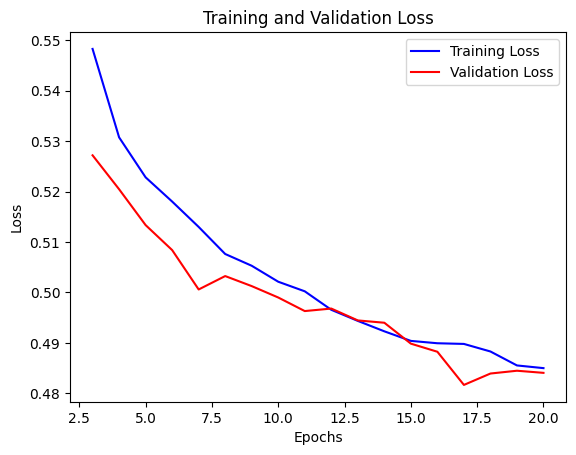

In [ ]:
plot_loss(trainer_state_path='output/checkpoint-10000/trainer_state.json')